In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config import api_key
import requests
import json

In [2]:
# Locate CSV files and convert to dataframes
STATE_DATA_PATH = "Resources/MN_2020_ADI_9 Digit Zip Code_v3.2.csv"
LOCAL_DATA_PATH = "Resources/Local_Repository_Data.csv"
PT_DATA_PATH = "Resources/Patient_Data.csv"

state_df = pd.read_csv(STATE_DATA_PATH)
local_df = pd.read_csv(LOCAL_DATA_PATH)
pt_df = pd.read_csv(PT_DATA_PATH)

C:\Users\jkaum\AppData\Local\Temp\ipykernel_4692\2531968484.py:6: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  state_df = pd.read_csv(STATE_DATA_PATH)


# DATA CLEANING
---
state_df cleaning

In [3]:
state_df.head()

,ZIP_4,GISJOIN,FIPS,ADI_NATRANK,ADI_STATERANK,TYPE
0,550010002,G27016300711022,2.716307e+11,12,1,
1,550010003,G27016300711022,2.716307e+11,12,1,
2,550010004,G27016300711022,2.716307e+11,12,1,
3,550010001,G27016300711022,2.716307e+11,12,1,
4,550010015,G27016300711022,2.716307e+11,12,1,


In [4]:
# Number of zip codes in state_df
print(f"There are {state_df.shape[0]} MN zip codes in state_df")

There are 1207314 MN zip codes in state_df


In [5]:
# Drop unwanted columns from state_df
clean_state_df = state_df.drop(["GISJOIN", "FIPS", "TYPE"], axis=1)
clean_state_df.head()

,ZIP_4,ADI_NATRANK,ADI_STATERANK
0,550010002,12,1
1,550010003,12,1
2,550010004,12,1
3,550010001,12,1
4,550010015,12,1


In [6]:
# Find bad data to drop
clean_state_df["ADI_STATERANK"].unique()

array(['1', '4', '3', '6', 'GQ-PH', '2', '5', '9', '8', '7', 'GQ', '10',
       'PH', nan, 8, 10, 7, 4, 9, 5, 6, 3, 1], dtype=object)

In [7]:
# Drop bad data
clean_state_df = clean_state_df.loc[(clean_state_df["ADI_STATERANK"] != "GQ") &
                                    (state_df["ADI_STATERANK"] != "PH") &
                                    (state_df["ADI_STATERANK"] != "GQ-PH")]
clean_state_df["ADI_STATERANK"].unique()

array(['1', '4', '3', '6', '2', '5', '9', '8', '7', '10', nan, 8, 10, 7,
       4, 9, 5, 6, 3, 1], dtype=object)

In [8]:
# Drop NaN data
clean_state_df = clean_state_df.dropna()

In [9]:
# Confirm that all bad data is dropped from ADI_STATERANK column
clean_state_df["ADI_STATERANK"].unique()

array(['1', '4', '3', '6', '2', '5', '9', '8', '7', '10', 8, 10, 7, 4, 9,
       5, 6, 3, 1], dtype=object)

In [10]:
# Confirm that all bad data is dropped from ADI_NATRANK column
clean_state_df["ADI_NATRANK"].unique()

array(['12', '11', '16', '35', '10', '39', '31', '50', '27', '42', '45',
       '22', '37', '74', '43', '62', '46', '40', '47', '34', '56', '67',
       '68', '69', '66', '70', '63', '41', '48', '38', '36', '57', '28',
       '25', '33', '29', '26', '30', '19', '55', '32', '49', '20', '18',
       '24', '23', '53', '54', '97', '14', '59', '15', '21', '17', '44',
       '73', '64', '81', '61', '58', '76', '60', '13', '9', '51', '8',
       '98', '5', '75', '86', '72', '65', '96', '84', '95', '77', '71',
       '82', '83', '6', '92', '52', '89', '80', '79', '78', '7', '99',
       '4', '100', '3', '2', '91', '85', '87', '93', '88', '94', '90', 60,
       62, 61, 96, 55, 63, 59, 39, 67, 44, 69, 42, 43, 74, 64, 79, 81, 70,
       77, 54, 68, 51, 46, 58, 52, 72, 82, 75, 80, 88, 56, 76, 45, 34, 90,
       65, 99, 40, 36, 78, 84, 83, 73, 86, 66, 31, 53, 50, 85],
      dtype=object)

In [11]:
# Reset the index after dropping rows
clean_state_df = clean_state_df.reset_index(drop=True)
clean_state_df.head()

,ZIP_4,ADI_NATRANK,ADI_STATERANK
0,550010002,12,1
1,550010003,12,1
2,550010004,12,1
3,550010001,12,1
4,550010015,12,1


In [12]:
# Print number of rows that were dropped during data cleaning
print(f"{state_df.shape[0] - clean_state_df.shape[0]} rows were dropped from state_df during data cleaning.")

29462 rows were dropped from state_df during data cleaning.


In [13]:
# Rename zip code column name to match the pt_data_df
clean_state_df = clean_state_df.rename(columns={"ZIP_4": "Zip Code (9-digit)"})
clean_state_df.head()

,Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK
0,550010002,12,1
1,550010003,12,1
2,550010004,12,1
3,550010001,12,1
4,550010015,12,1


---
local_df cleaning

In [14]:
local_df.head()

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit),Established
0,101,55407,554074563,7/9/2021
1,102,56377,563771274,7/1/2021
2,103,55454,554544400,6/10/2021
3,104,55416,554162527,7/15/2022
4,105,56441,564411422,7/21/2022


In [15]:
# Print the number of repositories
print(f"RoundtableRx has {local_df.shape[0]} local repositories where patients can get their medications.")

RoundtableRx has 22 local repositories where patients can get their medications.


In [16]:
# Drop unwanted columns
clean_local_df = local_df.drop("Established", axis=1)
clean_local_df.head()

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit)
0,101,55407,554074563
1,102,56377,563771274
2,103,55454,554544400
3,104,55416,554162527
4,105,56441,564411422


In [17]:
# Check for bad data
clean_local_df["Zip Code (5-digit)"].unique()

array([55407, 56377, 55454, 55416, 56441, 56401, 56636, 56501, 55063,
       55807, 55987, 55404, 55104, 55409, 55054, 55303, 55805],
      dtype=int64)

In [18]:
# Check for bad data
clean_local_df["Zip Code (9-digit)"].unique()

array([554074563, 563771274, 554544400, 554162527, 564411422, 564013575,
       566368779, 565013503, 550636026, 564013054, 558072730, 554071131,
       559876435, 558072737, 554043074, 551044201, 554091304, 554044515,
       550545483, 554042923, 553035566, 558051901], dtype=int64)

----
pt_df cleaning

In [19]:
pt_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit),Date Started or Renewed
0,113,2001,55987,559874346,1/30/2023
1,115,2002,55429,554292726,5/18/2021
2,115,2003,??,??,6/2/2021
3,115,2004,55407,554071135,8/20/2021
4,115,2005,55428,554282966,7/22/2022


In [20]:
# RoundtableRx serves 133 unique patients
print(f"RoundtableRx serves {pt_df.shape[0]} unique patients.")

RoundtableRx serves 133 unique patients.


In [21]:
# Drop unwanted columns
clean_pt_df = pt_df.drop("Date Started or Renewed", axis=1)
clean_pt_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit)
0,113,2001,55987,559874346
1,115,2002,55429,554292726
2,115,2003,??,??
3,115,2004,55407,554071135
4,115,2005,55428,554282966


In [22]:
# Check for bad data
clean_pt_df["Zip Code (5-digit)"].unique()

array(['55987', '55429', '??', '55407', '55428', '55417', '55434',
       '55418', '55413', '55423', '56679', '55792', '55810', '55720',
       '56649', '55804', '55805', '56401', '55807', '55724', '55705',
       '55812', '55795', '56470', '55803', '56636', '55753', '56571',
       '56573', '55797', '55744', '55811', '56484', '55760', '55782',
       '56450', '56672', '56501', '55779', '56473', '56474', '56554',
       '56637', '56544', '56449', '55722', '56655', '55020', '55044',
       '55088', '55054', '55378', '55057', '55616', '55454', '55106',
       '55406', '55303', '55126', '55433', '55343', '55304', '55025',
       '55387', '55117', '55346', '55110', '55362', '55404', '56444',
       '56441', '55119'], dtype=object)

In [23]:
# Check for bad data
clean_pt_df["Zip Code (9-digit)"].unique()

array(['559874346', '554292726', '??', '554071135', '554282966',
       '554172816', '554195500', '554072203', '554184420', '554131969',
       '554234333', '566790093', '557922844', '558109576', '557201311',
       '566493402', '558041646', '557922200', '558052044', '564012737',
       '566492805', '558072658', '557248533', '557051441', '558051823',
       '558043301', '558121751', '557953076', '558052073', '564701387',
       '558072542', '558043061', '558039436', '566360179', '557530641',
       '565719409', '565739010', '566363071', '557978718', '557442177',
       '557248209', '558111236', '564842171', '557605894', '557820385',
       '564509694', '566724575', '565012449', '558032034', '557797006',
       '566360395', '565013203', '566362044', '564732139', '558102022',
       '557923527', '558041806', '558121720', '558115323', '564014402',
       '566362205', '564746164', '565549002', '566372091', '565012909',
       '565448547', '558071922', '558071908', '558031945', '564491107',

In [24]:
# Drop bad data
clean_pt_df = clean_pt_df.loc[(clean_pt_df["Zip Code (9-digit)"] != "??") & (clean_pt_df["Zip Code (5-digit)"] != "??")]
clean_pt_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit)
0,113,2001,55987,559874346
1,115,2002,55429,554292726
3,115,2004,55407,554071135
4,115,2005,55428,554282966
5,115,2006,55417,554172816


In [25]:
# Reset the index after dropping rows
clean_pt_df = clean_pt_df.reset_index(drop=True)
clean_pt_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit)
0,113,2001,55987,559874346
1,115,2002,55429,554292726
2,115,2004,55407,554071135
3,115,2005,55428,554282966
4,115,2006,55417,554172816


In [26]:
# Print number of pts lost during data cleaning
print(f"{pt_df.shape[0] - clean_pt_df.shape[0]} patients were dropped during data cleaning.")

4 patients were dropped during data cleaning.


# Data Merging

In [27]:
# Before merging clean_pt_df and clean_state_df, ensure that common column is of the same dtype
clean_pt_df['Zip Code (9-digit)'] = clean_pt_df['Zip Code (9-digit)'].astype(int)
clean_state_df['Zip Code (9-digit)'] = clean_state_df['Zip Code (9-digit)'].astype(int)

In [28]:
# Merge clean_pt_df and clean_state_df so that we can get the ADI rank of each patient
pt_adi_df = pd.merge(clean_pt_df,clean_state_df, how="inner", on=["Zip Code (9-digit)", "Zip Code (9-digit)"])
pt_adi_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK
0,113,2001,55987,559874346,77,10
1,115,2002,55429,554292726,62,8
2,115,2004,55407,554071135,57,7
3,115,2005,55428,554282966,63,8
4,115,2006,55417,554172816,84,10


In [29]:
# Print number of pts lost during data merging
print(f"{clean_pt_df.shape[0] - pt_adi_df.shape[0]} patients were dropped during data merging.")

2 patients were dropped during data merging.


In [30]:
# Determine total number of patients with ADI ranks we can analyze
total_pts = pt_adi_df["Patient ID"].count()
print(f"ADI ranks are available for {total_pts} of RoundtableRx's patients.")

ADI ranks are available for 127 of RoundtableRx's patients.


In [31]:
# Before merging clean_local_df and clean_state_df, ensure that common column is of the same dtype
clean_local_df['Zip Code (9-digit)'] = clean_local_df['Zip Code (9-digit)'].astype(int)

In [32]:
# Merge clean_local_df and clean_state_df so that we can get the ADI rank of each local repository
local_adi_df = pd.merge(clean_local_df,clean_state_df, how="left", on=["Zip Code (9-digit)", "Zip Code (9-digit)"])
local_adi_df

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK
0,101,55407,554074563,44,5
1,102,56377,563771274,65,8
2,103,55454,554544400,NaN,NaN
3,104,55416,554162527,41,5
4,105,56441,564411422,58,7
5,106,56401,564013575,84,10
6,107,56636,566368779,90,10
7,108,56501,565013503,75,9
8,109,55063,550636026,63,8
9,110,56401,564013054,73,9


1.using geoapify (https://apidocs.geoapify.com/docs/geocoding/forward-geocoding/#geocode-zipcodes) add lat and lon columns as well get a county column to pt_adi_df and local_adi_df. get county column added to clean_state_df.
    - Ayan
    Travis

make the maps

2. get mean, mode for pt_adi_df ADI_STATERANK and ADI_NATRANK
    - Kokoe

make bar charts y = # of pts, x = ADIs core for pt_adi_df. state ranks only
    - Roli

3. pie chart ADI scores
    - Joanna

4. health access / health outcomes vs adi score per county

to create a new branch:     git checkout -b new-branch-name
to push to a branch:        git push origin new-branch-name

10 AM GROUP ON SATURDAY

2:30 GROUP ON SATURDAY


In [33]:
# Create a function to add latitude, longitude, and County columns to the state, local, and pt dataframes
def column_creation(dataframe):
    dataframe["LAT"]=""
    dataframe["LONG"] =""
    dataframe["County"]= ""  

In [34]:
# Run column_creation function on pt_adi_df
column_creation(pt_adi_df)
pt_adi_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK,LAT,LONG,County
0,113,2001,55987,559874346,77,10,,,
1,115,2002,55429,554292726,62,8,,,
2,115,2004,55407,554071135,57,7,,,
3,115,2005,55428,554282966,63,8,,,
4,115,2006,55417,554172816,84,10,,,


In [35]:
# Run column_creation function on local_adi_df
column_creation(local_adi_df)
local_adi_df.head()

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK,LAT,LONG,County
0,101,55407,554074563,44,5,,,
1,102,56377,563771274,65,8,,,
2,103,55454,554544400,NaN,NaN,,,
3,104,55416,554162527,41,5,,,
4,105,56441,564411422,58,7,,,


In [36]:
# Add the Zip Code (5-digit) column to the clean_state_df
clean_state_df['Zip Code (5-digit)'] = clean_state_df['Zip Code (9-digit)'].apply(lambda x: str(x)[:5])
clean_state_df.head()

,Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK,Zip Code (5-digit)
0,550010002,12,1,55001
1,550010003,12,1,55001
2,550010004,12,1,55001
3,550010001,12,1,55001
4,550010015,12,1,55001


In [37]:
# Create a dataframe that just has unique 5-digit MN zip codes and add empty columns for lat, long, and County
zip_county = {"Zip Code (5-digit)":clean_state_df["Zip Code (5-digit)"].unique(), "LAT": "", "LONG": "", "County": ""}
zip_county_df = pd.DataFrame(zip_county)
zip_county_df.head()

,Zip Code (5-digit),LAT,LONG,County
0,55001,,,
1,55003,,,
2,55005,,,
3,55006,,,
4,55007,,,


In [38]:
# Create a function to populate empty columns on state, local, and pt dataframes
def location_info(dataframe):
    for index, row in dataframe.iterrows():
        # Loop through zip codes
        zip_code = dataframe.loc[index, "Zip Code (5-digit)"]
        # define target url
        target_url = f"https://api.geoapify.com/v1/geocode/search?text={zip_code}&lang=en&limit=10&type=postcode&filter=countrycode:us&apiKey={api_key}"
        #get lat, lon, county
        latitude = dataframe.loc[index, "LAT"]
        longitude = dataframe.loc[index, "LONG"]
        county = dataframe.loc[index, "County"]
        # make API request
        response = requests.get(target_url).json()
        try:
            dataframe.loc[index, "LAT"] = response["features"][0]["properties"]["lat"]
            dataframe.loc[index, "LONG"] = response["features"][0]["properties"]["lon"]
            dataframe.loc[index, "County"] = response["features"][0]["properties"]["county"]
            print(f"{zip_code} found")
        except:
            dataframe.loc[index, "LAT"] = "Not Found"
            dataframe.loc[index, "LONG"] = "Not Found"
            dataframe.loc[index, "County"] = "Not Found"
            print(f"{zip_code} NOT found")


In [39]:
# # This function takes time to run so it was run just once, results saved as a csv and then commented out.
# # The path for the csv is "Output/local_repository_data_complete.csv"
# # csv later imported as local_adi_complete

# # Run location_info function on local_adi_df
# location_info(local_adi_df)
# local_adi_df

In [40]:
# # This function takes time to run so it was run just once, results saved as a csv and then commented out.
# # The path for the csv is "Output/patient_data_complete.csv"
# # csv later imported as pt_adi_complete

# # Run location_info function on pt_adi_df
# location_info(pt_adi_df)
# pt_adi_df

In [41]:
# # This function takes A LONG time to run so it was run just once, results saved as a csv and then commented out.
# # The path for the csv is "Output/local_repository_data_complete.csv"
# # csv later imported as state_complete

# # Run location_info function on zip_county_df
# location_info(zip_county_df)
# zip_county_df.head()

In [42]:
# # This function takes A LONG time to run so it was run just once, results saved as a csv and then commented out.
# # The path for the csv is "Output/local_repository_data_complete.csv"
# # csv later imported as state_complete

# # Drop any data where County was not found
# clean_zip_county_df = zip_county_df.loc[(zip_county_df["County"] != "NOT found")]
# clean_zip_county_df.head()

In [43]:
# # This function takes A LONG time to run so it was run just once, results saved as a csv and then commented out.
# # The path for the csv is "Output/local_repository_data_complete.csv"
# # csv later imported as state_complete

# # merge clean_zip_county_df with clean_state_df
# clean_state_df = pd.merge(clean_zip_county_df,clean_state_df, how="left", on=["Zip Code (5-digit)", "Zip Code (5-digit)"])
# clean_state_df.head()

In [44]:
# # This function was run once to save our final dataframes as csv files, then commented out so that we will not
# # mistakenly overwrite or append the csv files

# # Save completed dataframes to csv files. Once complete we will not have to run the location_info function
# # again, thus saving time whenever we need to restart the kernel
# local_adi_df.to_csv("Output/local_repository_data_complete.csv", index=False)
# pt_adi_df.to_csv("Output/patient_data_complete.csv", index=False)
# clean_state_df.to_csv("Output/ADI_data_complete.csv", index=False)

In [45]:
# Import CSV files and convert to dataframes
ADI_DATA_COMPLETE_PATH = "Output/ADI_data_complete.csv"
LOCAL_REPOSITORY_DATA_COMPLETE_PATH = "Output/local_repository_data_complete.csv"
PATIENT_DATA_COMPLETE_PATH = "Output/patient_data_complete.csv"


state_complete = pd.read_csv(ADI_DATA_COMPLETE_PATH)
local_adi_complete = pd.read_csv(LOCAL_REPOSITORY_DATA_COMPLETE_PATH)
pt_adi_complete = pd.read_csv(PATIENT_DATA_COMPLETE_PATH)

C:\Users\jkaum\AppData\Local\Temp\ipykernel_4692\3837688556.py:7: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  state_complete = pd.read_csv(ADI_DATA_COMPLETE_PATH)


In [46]:
state_complete.head()

,Zip Code (5-digit),LAT,LONG,County,Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK
0,55001,44.913206689,-92.805283599,Washington County,550010002,12,1
1,55001,44.913206689,-92.805283599,Washington County,550010003,12,1
2,55001,44.913206689,-92.805283599,Washington County,550010004,12,1
3,55001,44.913206689,-92.805283599,Washington County,550010001,12,1
4,55001,44.913206689,-92.805283599,Washington County,550010015,12,1


In [47]:
local_adi_complete.head()

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK,LAT,LONG,County
0,101,55407,554074563,44.0,5.0,44.938337,-93.253067,Hennepin County
1,102,56377,563771274,65.0,8.0,45.626310,-94.218518,Stearns County
2,103,55454,554544400,NaN,NaN,44.969891,-93.243023,Hennepin County
3,104,55416,554162527,41.0,5.0,44.947159,-93.342940,Hennepin County
4,105,56441,564411422,58.0,7.0,46.515680,-93.969317,Crow Wing County


In [ ]:
pt_adi_complete.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK,LAT,LONG,County
0,113,2001,55987,559874346,77,10,44.046447,-91.657487,Winona County
1,115,2002,55429,554292726,62,8,45.061817,-93.340607,Hennepin County
2,115,2004,55407,554071135,57,7,44.938337,-93.253067,Hennepin County
3,115,2005,55428,554282966,63,8,45.052188,-93.378094,Hennepin County
4,115,2006,55417,554172816,84,10,44.907389,-93.231786,Hennepin County


# Data Visualization

In [ ]:
# Set data type of ADI ranks to integers so we can perform statistical analysis
pt_adi_df['ADI_STATERANK'] = pt_adi_df['ADI_STATERANK'].astype(int)
pt_adi_df['ADI_NATRANK'] = pt_adi_df['ADI_NATRANK'].astype(int)

In [50]:
# Separating pt ADI ranks into 3 bins
pt_ADI_groups = pt_adi_df.copy()
bins_3 = [0, 4.9, 7.9, 10]
labels_3 = ["below 5", "5 to 7", "8 to 10"]
pt_ADI_groups["State ADI Rank (3 Groups)"] = pd.cut(pt_ADI_groups["ADI_STATERANK"], bins=bins_3,
                                                    labels=labels_3, include_lowest=True)

In [51]:
# Separating pt ADI ranks into 2 bins
bins_2 = [0, 4.9, 10]
labels_2 = ["below 5", "5 to 10"]
pt_ADI_groups["State ADI Rank (2 Groups)"] = pd.cut(pt_ADI_groups["ADI_STATERANK"], bins=bins_2,
                                                    labels=labels_2, include_lowest=True)

In [52]:
pt_ADI_groups.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK,LAT,LONG,County,State ADI Rank (3 Groups),State ADI Rank (2 Groups)
0,113,2001,55987,559874346,77,10,,,,8 to 10,5 to 10
1,115,2002,55429,554292726,62,8,,,,8 to 10,5 to 10
2,115,2004,55407,554071135,57,7,,,,5 to 7,5 to 10
3,115,2005,55428,554282966,63,8,,,,8 to 10,5 to 10
4,115,2006,55417,554172816,84,10,,,,8 to 10,5 to 10


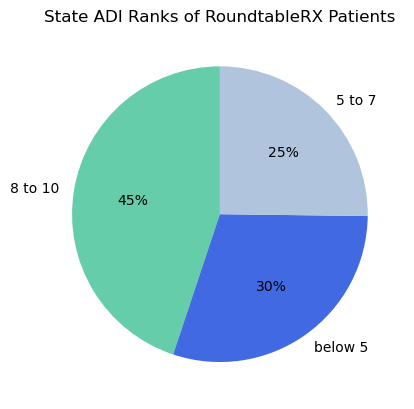

In [53]:
# Pie chart for 3 bins of pt ADI ranks
pts_per_ADI_group_3 = pt_ADI_groups["State ADI Rank (3 Groups)"].value_counts()
pts_per_ADI_group_3.plot(kind="pie", ylabel="", title="State ADI Ranks of RoundtableRX Patients",
                         colors=["mediumaquamarine", "royalblue", "lightsteelblue"], startangle = 90, autopct="%1.0f%%")
plt.show()


In [54]:
# Print stats for pts grouped into three ADI rank groups
pts_1to4 = pt_ADI_groups["State ADI Rank (3 Groups)"].loc[pt_ADI_groups["State ADI Rank (3 Groups)"] == "below 5"].count()
pts_5to7 = pt_ADI_groups["State ADI Rank (3 Groups)"].loc[pt_ADI_groups["State ADI Rank (3 Groups)"] == "5 to 7"].count()
pts_8to10 = pt_ADI_groups["State ADI Rank (3 Groups)"].loc[pt_ADI_groups["State ADI Rank (3 Groups)"] == "8 to 10"].count()

percent_1to4 = round(pts_1to4/total_pts *100)
percent_5to7 = round(pts_5to7/total_pts *100)
percent_8to10 = round(pts_8to10/total_pts *100)

print(f"{percent_1to4}% of RoundtableRx's patients have an ADI rank less than 5.")
print(f"{percent_5to7}% of RoundtableRx's patients have an ADI rank of 5, 6, or 7.")
print(f"{percent_8to10}% of RoundtableRx's patients have an ADI rank of 8, 9, or 10.")

30% of RoundtableRx's patients have an ADI rank less than 5.
25% of RoundtableRx's patients have an ADI rank of 5, 6, or 7.
45% of RoundtableRx's patients have an ADI rank of 8, 9, or 10.


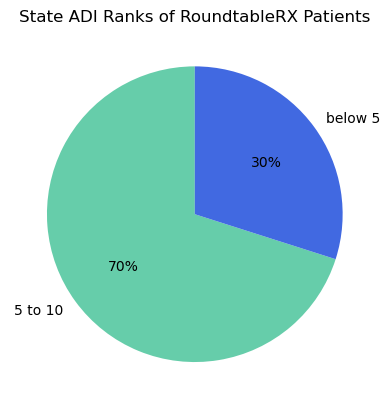

In [55]:
# Pie chart for 2 bins of pt ADI ranks
pts_per_ADI_group_2 = pt_ADI_groups["State ADI Rank (2 Groups)"].value_counts()
pts_per_ADI_group_2.plot(kind="pie", ylabel="", title="State ADI Ranks of RoundtableRX Patients",
                         colors=["mediumaquamarine", "royalblue"], startangle = 90, autopct="%1.0f%%")
plt.show()

In [56]:
# Print stats for pts grouped into two ADI rank groups
pts_above_5 = pt_ADI_groups["State ADI Rank (2 Groups)"].loc[pt_ADI_groups["State ADI Rank (2 Groups)"] == "5 to 10"].count()
pts_below_5 = pt_ADI_groups["State ADI Rank (2 Groups)"].loc[pt_ADI_groups["State ADI Rank (2 Groups)"] == "below 5"].count()
percent_below_5 = round(pts_below_5/total_pts *100)
percent_above_5 = round(pts_above_5/total_pts *100)
print(f"{percent_below_5}% of RoundtableRx's patients have an ADI rank less than 5.")
print(f"{percent_above_5}% of RoundtableRx's patients have an ADI rank of 5 or above.")

30% of RoundtableRx's patients have an ADI rank less than 5.
70% of RoundtableRx's patients have an ADI rank of 5 or above.


In [57]:
# Import prenatal data file and convert to dataframe
PNC_PATH = "Resources/MN_prenatal_care_2020.csv"

pnc_df = pd.read_csv(PNC_PATH)
pnc_df.head()

,County,PNC in First Trimester,Intensive PNC,Adequate PNC,Intermediate PNC,Inadequate PNC,Gave Birth Out of State
0,State of Minnesota,"50,281","17,122","28,296","8,900","6,248","2,383"
1,Aitkin,97,26,55,18,5,0
2,Anoka,"3,402","1,000","1,913",708,330,5
3,Becker,240,112,131,30,35,48
4,Beltrami,441,116,281,65,118,14


In [58]:
# Check data types
pnc_df.dtypes

County                     object
PNC in First Trimester     object
Intensive PNC              object
Adequate PNC               object
Intermediate PNC           object
Inadequate PNC             object
Gave Birth Out of State    object
dtype: object

In [59]:
# Remove commas from column data
pnc_df = pnc_df.replace(',','', regex=True)
pnc_df.head()

,County,PNC in First Trimester,Intensive PNC,Adequate PNC,Intermediate PNC,Inadequate PNC,Gave Birth Out of State
0,State of Minnesota,50281,17122,28296,8900,6248,2383
1,Aitkin,97,26,55,18,5,0
2,Anoka,3402,1000,1913,708,330,5
3,Becker,240,112,131,30,35,48
4,Beltrami,441,116,281,65,118,14


In [60]:
# Reformat number columns as integers
pnc_df = pnc_df.astype({"PNC in First Trimester": "int", "Intensive PNC": "int",
                        "Adequate PNC": "int", "Intermediate PNC": "int", "Inadequate PNC": "int",
                        "Gave Birth Out of State": "int"})

In [61]:
pnc_df.dtypes

County                     object
PNC in First Trimester      int32
Intensive PNC               int32
Adequate PNC                int32
Intermediate PNC            int32
Inadequate PNC              int32
Gave Birth Out of State     int32
dtype: object

In [62]:
# Create a column with total number of pts receiving prenatal care
pnc_df["Total PNC Patients"] = pnc_df["Intensive PNC"] + pnc_df["Adequate PNC"] + pnc_df["Intermediate PNC"] + pnc_df["Inadequate PNC"]
pnc_df.head()

,County,PNC in First Trimester,Intensive PNC,Adequate PNC,Intermediate PNC,Inadequate PNC,Gave Birth Out of State,Total PNC Patients
0,State of Minnesota,50281,17122,28296,8900,6248,2383,60566
1,Aitkin,97,26,55,18,5,0,104
2,Anoka,3402,1000,1913,708,330,5,3951
3,Becker,240,112,131,30,35,48,308
4,Beltrami,441,116,281,65,118,14,580


In [63]:
# Calculate the percentages of care quality and add as columns
total_pnc_pts = pnc_df["Total PNC Patients"]
pnc_df["% Inadequate PNC"] = pnc_df["Inadequate PNC"] / total_pnc_pts * 100
pnc_df["% Intermediate PNC"] = pnc_df["Intermediate PNC"] / total_pnc_pts * 100
pnc_df["% Adequate PNC"] = pnc_df["Adequate PNC"] / total_pnc_pts * 100
pnc_df["% Intensive PNC"] = pnc_df["Intensive PNC"] / total_pnc_pts * 100
pnc_df

,County,PNC in First Trimester,Intensive PNC,Adequate PNC,Intermediate PNC,Inadequate PNC,Gave Birth Out of State,Total PNC Patients,% Inadequate PNC,% Intermediate PNC,% Adequate PNC,% Intensive PNC
0,State of Minnesota,50281,17122,28296,8900,6248,2383,60566,10.316019,14.694713,46.719281,28.269986
1,Aitkin,97,26,55,18,5,0,104,4.807692,17.307692,52.884615,25.000000
2,Anoka,3402,1000,1913,708,330,5,3951,8.352316,17.919514,48.418122,25.310048
3,Becker,240,112,131,30,35,48,308,11.363636,9.740260,42.532468,36.363636
4,Beltrami,441,116,281,65,118,14,580,20.344828,11.206897,48.448276,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
83,Watonwan,109,26,70,30,38,0,164,23.170732,18.292683,42.682927,15.853659
84,Wilkin,14,7,7,0,0,40,14,0.000000,0.000000,50.000000,50.000000
85,Winona,249,50,153,60,47,126,310,15.161290,19.354839,49.354839,16.129032
86,Wright,1498,437,858,286,129,4,1710,7.543860,16.725146,50.175439,25.555556


In [64]:
# Add "County" after each county name so it matches other dataframes
pnc_df['County'] = pnc_df['County'] + ' County'
pnc_df.head()

,County,PNC in First Trimester,Intensive PNC,Adequate PNC,Intermediate PNC,Inadequate PNC,Gave Birth Out of State,Total PNC Patients,% Inadequate PNC,% Intermediate PNC,% Adequate PNC,% Intensive PNC
0,State of Minnesota County,50281,17122,28296,8900,6248,2383,60566,10.316019,14.694713,46.719281,28.269986
1,Aitkin County,97,26,55,18,5,0,104,4.807692,17.307692,52.884615,25.000000
2,Anoka County,3402,1000,1913,708,330,5,3951,8.352316,17.919514,48.418122,25.310048
3,Becker County,240,112,131,30,35,48,308,11.363636,9.740260,42.532468,36.363636
4,Beltrami County,441,116,281,65,118,14,580,20.344828,11.206897,48.448276,20.000000


In [65]:
# Reorder columns
pnc_df = pnc_df[["County", "Total PNC Patients","PNC in First Trimester", "Intensive PNC", "% Intensive PNC",
                 "Adequate PNC", "% Adequate PNC", "Intermediate PNC", "% Intermediate PNC", "Inadequate PNC",
                 "% Inadequate PNC"]] 
pnc_df.head()

,County,Total PNC Patients,PNC in First Trimester,Intensive PNC,% Intensive PNC,Adequate PNC,% Adequate PNC,Intermediate PNC,% Intermediate PNC,Inadequate PNC,% Inadequate PNC
0,State of Minnesota County,60566,50281,17122,28.269986,28296,46.719281,8900,14.694713,6248,10.316019
1,Aitkin County,104,97,26,25.000000,55,52.884615,18,17.307692,5,4.807692
2,Anoka County,3951,3402,1000,25.310048,1913,48.418122,708,17.919514,330,8.352316
3,Becker County,308,240,112,36.363636,131,42.532468,30,9.740260,35,11.363636
4,Beltrami County,580,441,116,20.000000,281,48.448276,65,11.206897,118,20.344828


In [66]:
# Get average ADI scores for each county
county_adi = state_complete.groupby(["County"]).mean()["ADI_STATERANK"]
county_adi = pd.DataFrame(county_adi)
county_adi = county_adi.reset_index()
county_adi.head()

C:\Users\jkaum\AppData\Local\Temp\ipykernel_4692\2254120614.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  county_adi = state_complete.groupby(["County"]).mean()["ADI_STATERANK"]


,County,ADI_STATERANK
0,Aitkin County,7.389803
1,Anoka County,4.892094
2,Becker County,7.715064
3,Beltrami County,8.150926
4,Benton County,6.548735


In [67]:
# Merge dataframes so we have prenatal care + ADI ranks for each county combined into one dataframe
pnc_adi = pd.merge(pnc_df, county_adi)
pnc_adi

,County,Total PNC Patients,PNC in First Trimester,Intensive PNC,% Intensive PNC,Adequate PNC,% Adequate PNC,Intermediate PNC,% Intermediate PNC,Inadequate PNC,% Inadequate PNC,ADI_STATERANK
0,Aitkin County,104,97,26,25.000000,55,52.884615,18,17.307692,5,4.807692,7.389803
1,Anoka County,3951,3402,1000,25.310048,1913,48.418122,708,17.919514,330,8.352316,4.892094
2,Becker County,308,240,112,36.363636,131,42.532468,30,9.740260,35,11.363636,7.715064
3,Beltrami County,580,441,116,20.000000,281,48.448276,65,11.206897,118,20.344828,8.150926
4,Benton County,480,389,138,28.750000,239,49.791667,62,12.916667,41,8.541667,6.548735
...,...,...,...,...,...,...,...,...,...,...,...,...
80,Watonwan County,164,109,26,15.853659,70,42.682927,30,18.292683,38,23.170732,9.255688
81,Wilkin County,14,14,7,50.000000,7,50.000000,0,0.000000,0,0.000000,8.218109
82,Winona County,310,249,50,16.129032,153,49.354839,60,19.354839,47,15.161290,7.428822
83,Wright County,1710,1498,437,25.555556,858,50.175439,286,16.725146,129,7.543860,5.550285


# Barcharts 


In [56]:
state_complete = state_complete.dropna()
state_complete

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK,LAT,LONG,County
0,101,55407,554074563,44.0,5.0,44.938337,-93.253067,Hennepin County
1,102,56377,563771274,65.0,8.0,45.626310,-94.218518,Stearns County
3,104,55416,554162527,41.0,5.0,44.947159,-93.342940,Hennepin County
4,105,56441,564411422,58.0,7.0,46.515680,-93.969317,Crow Wing County
5,106,56401,564013575,84.0,10.0,46.356658,-94.191835,Crow Wing County
6,107,56636,566368779,90.0,10.0,47.404269,-93.832136,Itasca County
7,108,56501,565013503,75.0,9.0,46.828818,-95.792014,Becker County
8,109,55063,550636026,63.0,8.0,45.810609,-92.958571,Pine County
9,110,56401,564013054,73.0,9.0,46.356658,-94.191835,Crow Wing County
10,111,55807,558072730,73.0,9.0,46.738435,-92.170793,Saint Louis County


In [57]:

state_complete

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK,LAT,LONG,County
0,101,55407,554074563,44.0,5.0,44.938337,-93.253067,Hennepin County
1,102,56377,563771274,65.0,8.0,45.626310,-94.218518,Stearns County
3,104,55416,554162527,41.0,5.0,44.947159,-93.342940,Hennepin County
4,105,56441,564411422,58.0,7.0,46.515680,-93.969317,Crow Wing County
5,106,56401,564013575,84.0,10.0,46.356658,-94.191835,Crow Wing County
6,107,56636,566368779,90.0,10.0,47.404269,-93.832136,Itasca County
7,108,56501,565013503,75.0,9.0,46.828818,-95.792014,Becker County
8,109,55063,550636026,63.0,8.0,45.810609,-92.958571,Pine County
9,110,56401,564013054,73.0,9.0,46.356658,-94.191835,Crow Wing County
10,111,55807,558072730,73.0,9.0,46.738435,-92.170793,Saint Louis County


In [59]:
state_complete_ADI = state_complete.groupby('County')['ADI_STATERANK'].mean()
state_complete_ADI

County
Becker County          9.000000
Crow Wing County       8.666667
Hennepin County        6.000000
Itasca County         10.000000
Pine County            8.000000
Ramsey County          9.000000
Saint Louis County     9.666667
Scott County           2.000000
Stearns County         8.000000
Winona County          7.000000
Name: ADI_STATERANK, dtype: float64

In [73]:
state_complete_ADI_df = pd.DataFrame(state_complete_ADI)
state_complete_ADI_df

,ADI_STATERANK
County,
Becker County,9.000000
Crow Wing County,8.666667
Hennepin County,6.000000
Itasca County,10.000000
Pine County,8.000000
Ramsey County,9.000000
Saint Louis County,9.666667
Scott County,2.000000
Stearns County,8.000000


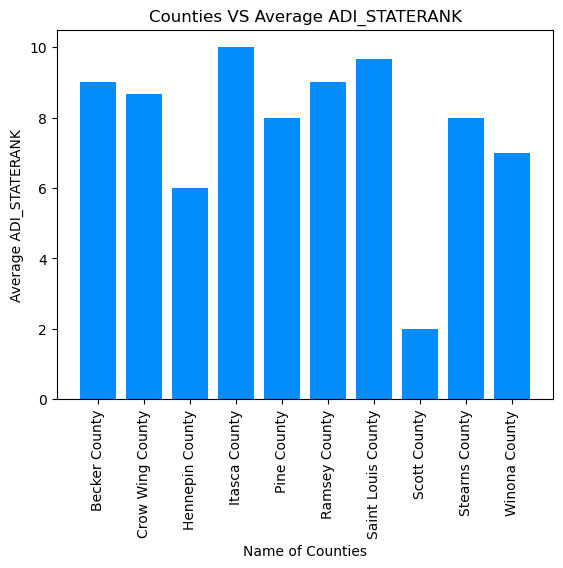

In [79]:
# plot barcharts
x_axis = state_complete_ADI_df.index
y_axis = state_complete_ADI_df['ADI_STATERANK']
plt.xticks(rotation = 'vertical')
plt.xlabel('Name of Counties')
plt.ylabel('Average ADI_STATERANK')
plt.title("Counties VS Average ADI_STATERANK")
plt.bar(x_axis , y_axis,color ='#038cfc')
plt.show()

In [80]:
local_adi_complete1 = local_adi_complete.groupby('County')['Patient ID'].nunique()
local_adi_complete_df = pd.DataFrame(local_adi_complete1)

local_adi_complete_df

,Patient ID
County,
Aitkin County,1
Anoka County,8
Becker County,6
Carlton County,2
Carver County,1
Cass County,5
Crow Wing County,7
Dakota County,2
Hennepin County,18


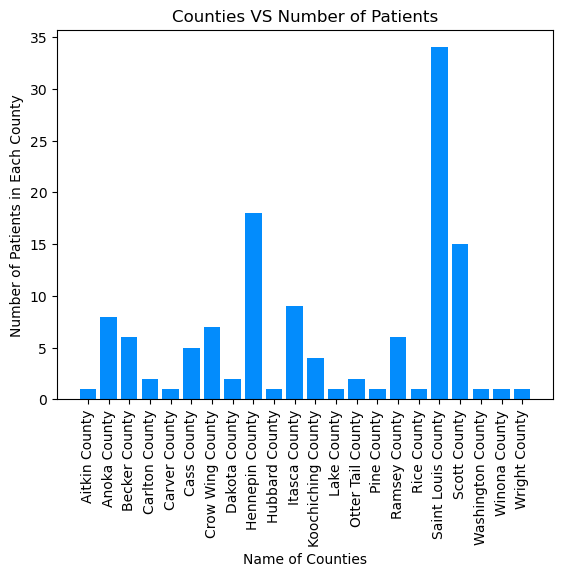

In [81]:
# plotting barcahrts to show unique no.of patients in each county
plt.bar(local_adi_complete_df.index, local_adi_complete_df['Patient ID'],color ='#038cfc')
plt.xticks(rotation = 'vertical')
plt.xlabel('Name of Counties')
plt.ylabel('Number of Patients in Each County')
plt.title("Counties VS Number of Patients")
plt.show()

In [82]:
#comparing number of repositoreis in each county
local_adi_complete2 = local_adi_complete.groupby('County')['Local Repository ID'].nunique()
local_adi_complete_df1 = pd.DataFrame(local_adi_complete2)

local_adi_complete_df1

,Local Repository ID
County,
Aitkin County,1
Anoka County,2
Becker County,1
Carlton County,2
Carver County,1
Cass County,2
Crow Wing County,4
Dakota County,1
Hennepin County,5


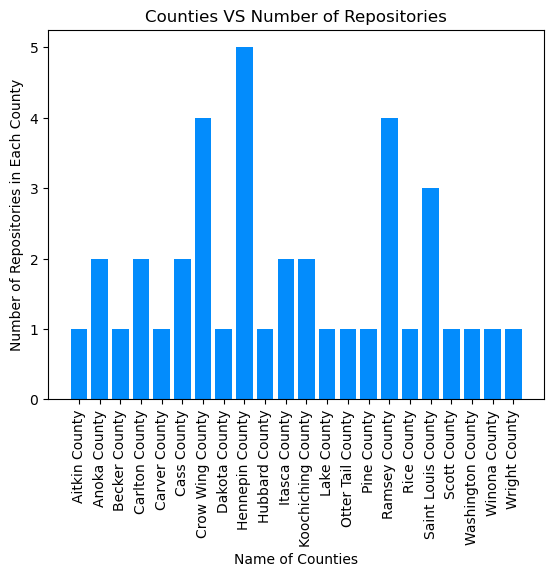

In [85]:
# plotting barcahrts to show unique no.of repositories in each county
plt.bar(local_adi_complete_df1.index, local_adi_complete_df1['Local Repository ID'],color ='#038cfc')
plt.xticks(rotation = 'vertical')
plt.xlabel('Name of Counties')
plt.ylabel('Number of Repositories in Each County')
plt.title("Counties VS Number of Repositories")
plt.show()